In [512]:
# Run some setup code for this notebook.
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Load Data

In [513]:
def load_data(path):
    df = pd.read_json(path)

    # 在展开 'user' 之前，先删除原始的 'created_at' 列
    if 'created_at' in df.columns:
        df = df.drop('created_at', axis=1)

    df_expanded = df['user'].apply(lambda x: pd.Series(x))
    df = pd.concat([df.drop('user', axis=1), df_expanded], axis=1)
    return df

data_train = load_data("./data/train.json") 
data_test = load_data("./data/test.json")
data_train.head()

,label,id,id_str,name,screen_name,location,description,url,entities,protected,followers_count,friends_count,listed_count,created_at,favourites_count,utc_offset,time_zone,geo_enabled,verified,statuses_count,lang,contributors_enabled,is_translator,is_translation_enabled,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_image_url_https,profile_banner_url,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type
0,bot,1318284638,1318284638,Syed Haider Naqvi,HNakvi,Islamabad,,None,{'description': {'urls': []}},False,28533,1164,45,Sun Mar 31 12:21:09 +0000 2013,6006,None,None,True,False,7446,en,False,False,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,http://pbs.twimg.com/profile_images/1086531658...,https://pbs.twimg.com/profile_images/108653165...,https://pbs.twimg.com/profile_banners/13182846...,1DA1F2,C0DEED,DDEEF6,333333,True,False,True,False,False,False,False,none
1,bot,17442457,17442457,Cleveland Clinic MD,CleClinicMD,"Cleveland, Ohio, United States",News and insights for physicians and clinical ...,https://t.co/IxMra2OEey,{'url': {'urls': [{'url': 'https://t.co/IxMra2...,False,299192,1721,1517,Mon Nov 17 14:46:49 +0000 2008,401,None,None,True,True,25344,en,False,False,False,0968AA,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,http://pbs.twimg.com/profile_images/9254239547...,https://pbs.twimg.com/profile_images/925423954...,https://pbs.twimg.com/profile_banners/17442457...,1C6EC4,D6E9F6,D6E9F6,333333,True,False,False,False,False,False,False,none
2,bot,102069605,102069605,2NE1 TV,2NE1tv,Seoul,We tweet about 2NE1's video and photo. It’s 2N...,None,{'description': {'urls': []}},False,89051,743,307,Tue Jan 05 14:06:26 +0000 2010,154,None,None,False,False,47479,ko,False,False,False,EDECE9,http://abs.twimg.com/images/themes/theme3/bg.gif,https://abs.twimg.com/images/themes/theme3/bg.gif,False,http://pbs.twimg.com/profile_images/6898294044...,https://pbs.twimg.com/profile_images/689829404...,https://pbs.twimg.com/profile_banners/10206960...,088253,D3D2CF,E3E2DE,634047,True,False,False,False,False,False,False,none
3,bot,1367759732,1367759732,Alastair de kretser,Alastairkretser,England,"Travel, tech and stuff 😀",None,{'description': {'urls': []}},False,43211,237,29,Sat Apr 20 18:55:44 +0000 2013,358,None,None,False,False,16586,en,False,False,False,022330,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,True,http://pbs.twimg.com/profile_images/7391332918...,https://pbs.twimg.com/profile_images/739133291...,https://pbs.twimg.com/profile_banners/13677597...,ABB8C2,000000,DDEEF6,333333,True,True,False,False,False,False,False,none
4,bot,2927879268,2927879268,Gran Horóscopo,GranHoroscopo,México - Argentina,Tu mejor prediccion diaria ORIGINAL para todos...,https://t.co/rDVUTyCn9E,{'url': {'urls': [{'url': 'https://t.co/rDVUTy...,False,113300,16422,112,Sat Dec 13 00:20:53 +0000 2014,37,None,None,True,False,70666,es,False,False,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,http://pbs.twimg.com/profile_images/5623928815...,https://pbs.twimg.com/profile_images/562392881...,https://pbs.twimg.com/profile_banners/29278792...,1DA1F2,C0DEED,DDEEF6,333333,True,False,True,False,False,False,False,regular


## Data Process

In [514]:
# 获取 'utc_offset' 字段的所有独特值
utc_offset_unique = data_train['utc_offset'].unique()
print("Unique values in 'utc_offset':", utc_offset_unique)

# 获取 'time_zone' 字段的所有独特值
time_zone_unique = data_train['time_zone'].unique()
print("Unique values in 'time_zone':", time_zone_unique)

protected_unique = data_train['protected'].unique()
print("Unique values in 'protected':", protected_unique)

notifications_unique = data_train['notifications'].unique()
print("Unique values in 'notifications':", notifications_unique)

# default_profile_image_unique = data_train['default_profile_image'].unique()
# print("Unique values in 'default_profile_image':", default_profile_image_unique)

# following_unique = data_train['following'].unique()
# print("Unique values in 'following':", following_unique)

follow_request_sent_unique = data_train['follow_request_sent'].unique()
print("Unique values in 'follow_request_sent':", follow_request_sent_unique)

# is_translation_enabled_unique = data_train['is_translation_enabled'].unique()
# print("Unique values in 'is_translation_enabled':", is_translation_enabled_unique)

# is_translator_unique = data_train['is_translator'].unique()
# print("Unique values in 'is_translator':", is_translator_unique)

contributors_enabled_unique = data_train['contributors_enabled'].unique()
print("Unique values in 'contributors_enabled':", contributors_enabled_unique)


Unique values in 'utc_offset': [None]
Unique values in 'time_zone': [None]
Unique values in 'protected': [False]
Unique values in 'notifications': [False]
Unique values in 'follow_request_sent': [False]
Unique values in 'contributors_enabled': [False]


### simple feature

In [515]:
data_train['label'] = data_train['label'].apply(lambda x: 1 if x == 'human' else 0)

data_train = data_train.drop('id', axis=1)


X = data_train[['label', 'url', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'verified', 'geo_enabled', 'lang',
                'statuses_count', 'profile_background_tile', 'profile_use_background_image', 'has_extended_profile', 'default_profile',
                'protected']].copy()

# 对 'url' 进行编码
X.loc[:, 'url'] = X['url'].apply(lambda x: 0 if x is None else 1)
X.loc[:, 'followers_count'] = np.log1p(X['followers_count'])
X.loc[:, 'friends_count'] = np.log1p(X['friends_count'])
X.loc[:, 'listed_count'] = np.log1p(X['listed_count'])
X.loc[:, 'favourites_count'] = np.log1p(X['favourites_count'])
X.loc[:, 'statuses_count'] = np.log1p(X['statuses_count'])

weekdays_mapping = {
    'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 
    'Fri': 5, 'Sat': 6, 'Sun': 7
}

split_columns = data_train['created_at'].str.split(' ', expand=True)
split_columns.columns = ['week', 'month', 'day', 'time', 'time_offset', 'zone_year']
time_split = split_columns['time'].str.split(':', expand=True)
time_split.columns = ['hour', 'minute', 'second']

X.loc[:, 'created_hour'] = time_split['hour'].astype(int)

X.loc[:, 'created_week'] = split_columns['week'].map(weekdays_mapping)


X.loc[:, 'geo_enabled'] = data_train['geo_enabled'].apply(lambda x: 1 if x else 0)
X.loc[:, 'verified'] = data_train['verified'].apply(lambda x: 1 if x else 0)
X.loc[:, 'profile_background_tile'] = data_train['profile_background_tile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'profile_use_background_image'] = data_train['profile_use_background_image'].apply(lambda x: 1 if x else 0)
X.loc[:, 'has_extended_profile'] = data_train['has_extended_profile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'default_profile'] = data_train['default_profile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'protected'] = data_train['protected'].apply(lambda x: 1 if x else 0)
X.loc[:, 'notifications'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'default_profile_image'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'following'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'follow_request_sent'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'is_translation_enabled'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'is_translator'] = data_train['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'contributors_enabled'] = data_train['notifications'].apply(lambda x: 1 if x else 0)


language_mapping = {
    'en': 1, 'pt': 2, 'nl': 3, 'tr': 4, 'it': 5, 'th': 6, 'de': 7, 'en-gb': 8,
    'id': 9, 'es': 10, 'fr': 11, 'ru': 12, 'ar': 13, 'ca': 14, 'ja': 15,
    'pl': 16, 'ko': 17
}

X.loc[:, 'lang'] = data_train['lang'].map(lambda x: language_mapping.get(x, 18))



translator_type_mapping = {
    'none': 0,
    'regular': 1,
    'badged': 2
}
X['translator_type'] = data_train['translator_type'].map(lambda x: translator_type_mapping.get(x, 3))

def hex_to_int(hex_string):
    return int(hex_string, 16)

X['profile_text_color'] = data_train['profile_text_color'].apply(hex_to_int)
X['profile_sidebar_fill_color'] = data_train['profile_sidebar_fill_color'].apply(hex_to_int)
X['profile_sidebar_border_color'] = data_train['profile_sidebar_border_color'].apply(hex_to_int)
X['profile_link_color'] = data_train['profile_link_color'].apply(hex_to_int)
X['profile_background_color'] = data_train['profile_background_color'].apply(hex_to_int)


X.head()

,label,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,protected,created_hour,created_week,notifications,default_profile_image,following,follow_request_sent,is_translation_enabled,is_translator,contributors_enabled,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color
0,0,0,10.258852,7.060476,3.828641,8.700681,0,1,1,8.915567,0,1,0,1,0,12,7,0,0,0,0,0,0,0,0,3355443,14544630,12639981,1942002,12639981
1,0,1,12.608844,7.451242,7.325149,5.996452,1,1,1,10.140337,0,1,0,0,0,14,1,0,0,0,0,0,0,0,0,3355443,14084598,14084598,1863364,616618
2,0,0,11.396976,6.612041,5.730100,5.043425,0,0,17,10.768064,0,1,0,0,0,14,2,0,0,0,0,0,0,0,0,6504519,14934750,13882063,557651,15592681
3,0,0,10.673874,5.472271,3.401197,5.883322,0,0,1,9.716375,1,1,1,0,0,18,6,0,0,0,0,0,0,0,0,3355443,14544630,0,11253954,140080
4,0,1,11.637803,9.706438,4.727388,3.637586,0,1,10,11.165734,0,1,0,1,0,0,6,0,0,0,0,0,0,0,1,3355443,14544630,12639981,1942002,12639981


### deal with name and description

In [516]:
def categorize_similarity(name, screen_name):
    similarity = fuzz.partial_ratio(name, screen_name)
    if similarity == 0:
        return 0
    elif 0 < similarity <= 40:
        return 1
    elif 40 < similarity <= 70:
        return 2
    elif 70 < similarity <= 90:
        return 3
    else:
        return 4

X['name_similarity'] = data_train.apply(lambda row: categorize_similarity(row['name'], row['screen_name']), axis=1)


def extract_url_count_in_description(entities):
    try:
        urls = entities.get('description', {}).get('urls', [])
        return len(urls)
    except AttributeError:
        return 0

X['num_url_in_description'] = data_train['entities'].apply(extract_url_count_in_description)


def split_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' \g<0> ', text)  

def count_tokens(description):
    if pd.isna(description):
        return 0
    description = split_emoji(description)
    tokens = word_tokenize(description)
    return len(tokens)

X['token_num_description'] = data_train['description'].apply(count_tokens)


pd.set_option('display.max_columns', None)
X.head() 

,label,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,protected,created_hour,created_week,notifications,default_profile_image,following,follow_request_sent,is_translation_enabled,is_translator,contributors_enabled,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color,name_similarity,num_url_in_description,token_num_description
0,0,0,10.258852,7.060476,3.828641,8.700681,0,1,1,8.915567,0,1,0,1,0,12,7,0,0,0,0,0,0,0,0,3355443,14544630,12639981,1942002,12639981,2,0,0
1,0,1,12.608844,7.451242,7.325149,5.996452,1,1,1,10.140337,0,1,0,0,0,14,1,0,0,0,0,0,0,0,0,3355443,14084598,14084598,1863364,616618,3,0,20
2,0,0,11.396976,6.612041,5.730100,5.043425,0,0,17,10.768064,0,1,0,0,0,14,2,0,0,0,0,0,0,0,0,6504519,14934750,13882063,557651,15592681,2,0,15
3,0,0,10.673874,5.472271,3.401197,5.883322,0,0,1,9.716375,1,1,1,0,0,18,6,0,0,0,0,0,0,0,0,3355443,14544630,0,11253954,140080,3,0,6
4,0,1,11.637803,9.706438,4.727388,3.637586,0,1,10,11.165734,0,1,0,1,0,0,6,0,0,0,0,0,0,0,1,3355443,14544630,12639981,1942002,12639981,3,2,20


### Normalized

In [517]:
from sklearn.preprocessing import MinMaxScaler

y = X['label']
X = X.drop('label', axis=1)
X = X.drop('protected', axis=1)
X = X.drop('notifications', axis=1)
X = X.drop('follow_request_sent', axis=1)
X = X.drop('contributors_enabled', axis=1)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X.head()
# y.head()
# X.shape, y.shape


,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,created_hour,created_week,default_profile_image,following,is_translation_enabled,is_translator,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color,name_similarity,num_url_in_description,token_num_description
0,0.0,0.554900,0.484359,0.287534,0.635336,0.0,1.0,0.0000,0.581503,0.0,1.0,0.0,1.0,0.521739,1.000000,0.0,0.0,0.0,0.0,0.0,0.2000,0.866928,0.753402,0.115844,0.753402,0.50,0.0,0.000000
1,1.0,0.682010,0.511166,0.550124,0.437870,1.0,1.0,0.0000,0.668120,0.0,1.0,0.0,0.0,0.608696,0.000000,0.0,0.0,0.0,0.0,0.0,0.2000,0.839508,0.839508,0.111153,0.036753,0.75,0.0,0.454545
2,0.0,0.616461,0.453595,0.430334,0.368278,0.0,0.0,1.0000,0.712514,0.0,1.0,0.0,0.0,0.608696,0.166667,0.0,0.0,0.0,0.0,0.0,0.3877,0.890181,0.827435,0.033265,0.929396,0.50,0.0,0.340909
3,0.0,0.577348,0.375405,0.255432,0.429609,0.0,0.0,0.0000,0.638137,1.0,1.0,1.0,0.0,0.782609,0.833333,0.0,0.0,0.0,0.0,0.0,0.2000,0.866928,0.000000,0.671318,0.008349,0.75,0.0,0.136364
4,1.0,0.629487,0.665875,0.355030,0.265622,0.0,1.0,0.5625,0.740638,0.0,1.0,0.0,1.0,0.000000,0.833333,0.0,0.0,0.0,0.0,0.5,0.2000,0.866928,0.753402,0.115844,0.753402,0.75,0.4,0.454545


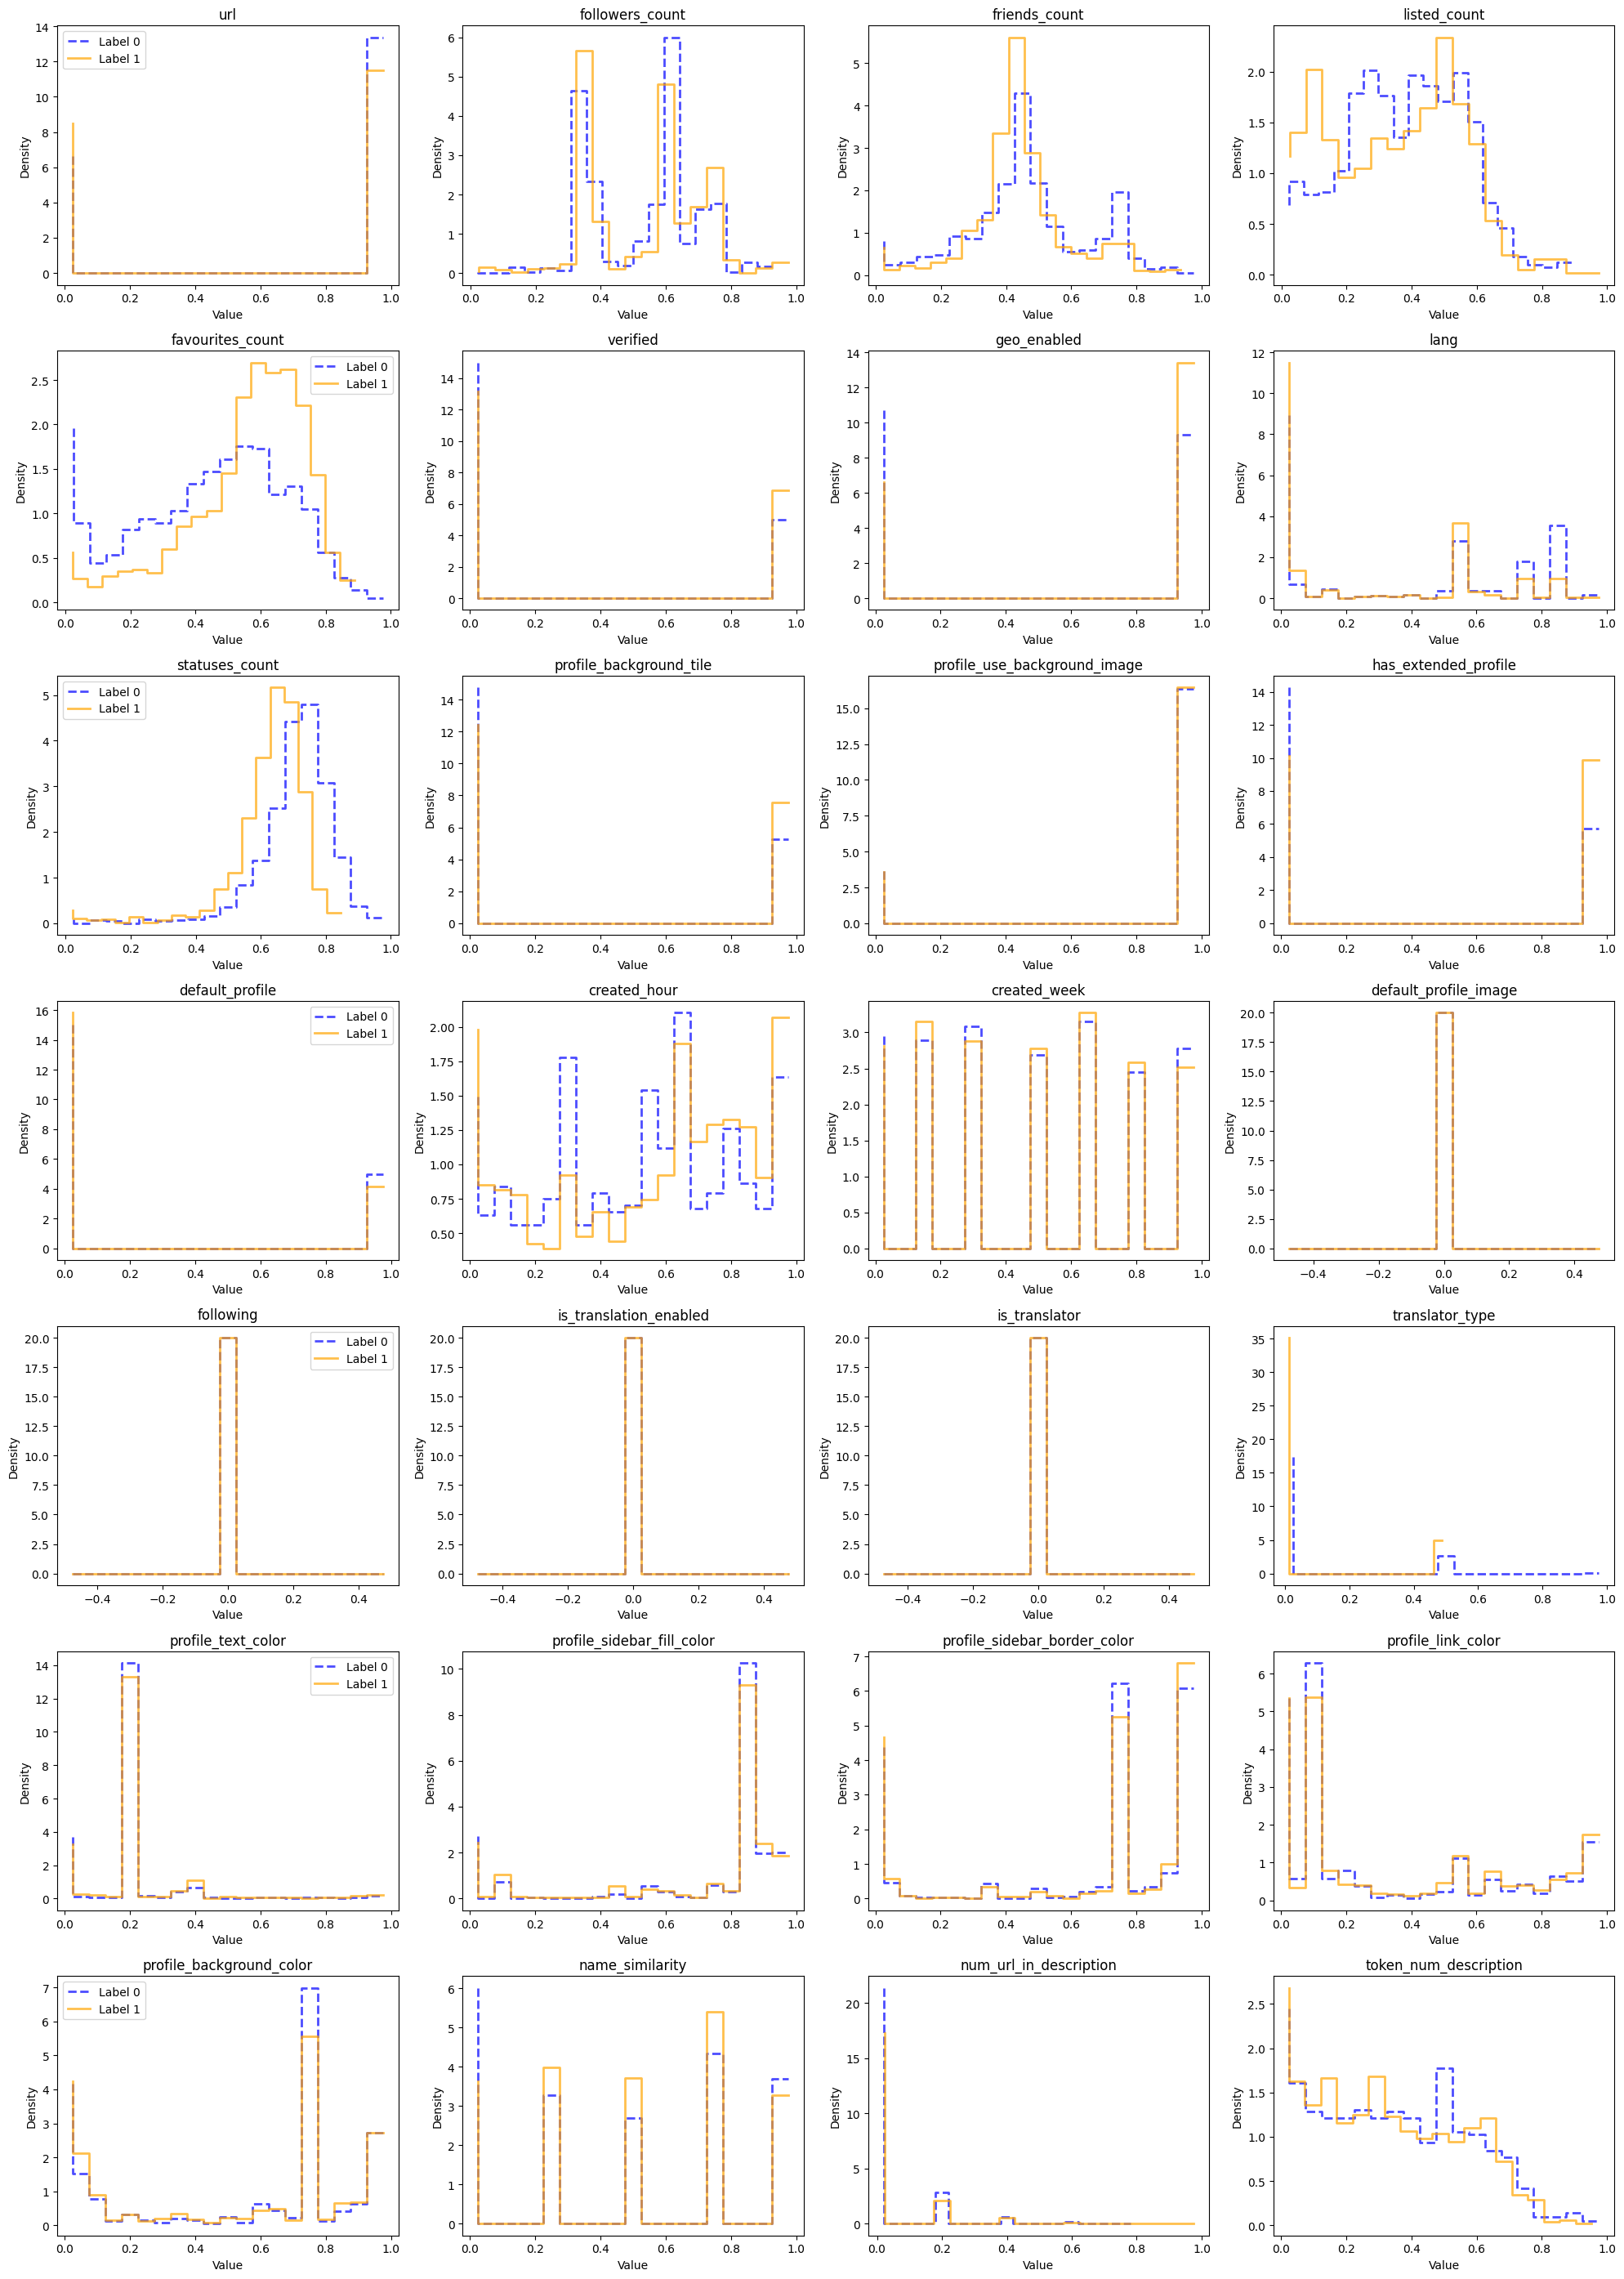

In [518]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = {0: 'blue', 1: 'orange'}
line_styles = {0: 'dashed', 1: 'solid'}

n_features = X.shape[1]
n_cols = 4
n_rows = n_features // n_cols + (n_features % n_cols > 0)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(X.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    for label in np.unique(y):
        feature_values = X[feature][y == label]
        counts, bin_edges = np.histogram(feature_values, bins=20, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts, label=f'Label {label}', color=colors[label],
                 linestyle=line_styles[label], alpha=0.7, linewidth=2, drawstyle='steps')

    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Density')
    if i % n_cols == 0:
        plt.legend()

plt.tight_layout()
plt.show()

### spile dataset

In [519]:
np.random.seed(3)
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(len(X) * 0.75)
# train : test = 3 : 1
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_test, y_test = X.iloc[test_index], y.iloc[test_index]

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_test.head()

,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,created_hour,created_week,default_profile_image,following,is_translation_enabled,is_translator,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color,name_similarity,num_url_in_description,token_num_description
1894,1.0,0.672774,0.367469,0.303636,0.804577,0.0,1.0,0.1875,0.631994,0.0,1.0,1.0,0.0,0.608696,0.666667,0.0,0.0,0.0,0.0,0.5,0.200000,0.964706,0.933333,0.013763,0.675275,0.75,0.0,0.250000
15,0.0,0.668200,0.328429,0.302307,0.352571,0.0,0.0,0.7500,0.720678,0.0,1.0,0.0,1.0,0.130435,0.500000,0.0,0.0,0.0,0.0,0.0,0.200000,0.866928,0.753402,0.115844,0.753402,0.00,0.0,0.136364
1695,1.0,0.615991,0.437685,0.377297,0.000000,1.0,1.0,0.0000,0.542432,0.0,0.0,0.0,0.0,0.130435,1.000000,0.0,0.0,0.0,0.0,0.0,0.200000,0.866928,1.000000,0.002026,1.000000,1.00,0.0,0.090909
535,1.0,0.681370,0.432243,0.485261,0.000000,1.0,0.0,0.1875,0.645026,0.0,1.0,0.0,0.0,0.608696,0.000000,0.0,0.0,0.0,0.0,0.0,0.200000,0.866928,1.000000,0.186715,0.101976,0.50,0.0,0.386364
1508,1.0,0.742301,0.494875,0.628773,0.597523,1.0,1.0,0.0625,0.685254,0.0,1.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.047806,0.116015,0.000076,0.594660,0.000000,0.75,0.0,0.363636


In [520]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Logistic Regression

In [521]:
class LogisticRegression:
    def __init__(self, num_iter=3000, fit_intercept=True, verbose=False):
        # self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y, lr=0.01):
        self.lr = lr
        y = np.mat(y, dtype = float)  
        y = y.A1
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        self.theta = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

            if(self.verbose == True and i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(f'loss: {self.__loss(h, y)} \t')

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold

In [522]:
import matplotlib.pyplot as plt

classifier = LogisticRegression()
classifier.fit(X_train, y_train, lr = 0.01)

In [523]:
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    return correct_predictions / y_true.shape[0]

y_pred = classifier.predict(X_test)
y_pred = np.mat(y_pred, dtype = int)
y_test_1 = np.mat(y_test, int)
acc = accuracy(y_test_1, y_pred.T)
# accuracy = np.maen(y_test == y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.6961770623742455


### 4-fold

In [524]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train, lr=0.01)

    y_pred = classifier.predict(X_test)
    y_pred = np.array(y_pred, dtype=int)

    acc = accuracy(y_test.values, y_pred)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)
print("Accuracy scores for each fold:", accuracies)
print("Average accuracy:", average_accuracy)

Accuracy scores for each fold: [0.7022132796780685, 0.7082494969818913, 0.6774193548387096, 0.6693548387096774]
Average accuracy: 0.6893092425520867


## Decision Tree

In [525]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# clf = DecisionTreeClassifier()

clf = DecisionTreeClassifier(
    criterion='entropy',      # 分割质量的衡量标准
    splitter='best',          # 分割节点的策略
    max_depth=5,              # 树的最大深度
    min_samples_split=2,      # 分割内部节点所需的最小样本数
    min_samples_leaf=2,       # 叶节点上所需的最小样本数
    max_features=None,        # 在寻找最佳分割时考虑的最大特征数
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7399193548387096


### 网络搜索调参

In [526]:
"""from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 8, 10, 12, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")"""

'from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'splitter\': [\'best\', \'random\'],\n    \'max_depth\': [5, 8, 10, 12, 15],\n    \'min_samples_split\': [2, 5, 10, 20],\n    \'min_samples_leaf\': [1, 2, 5, 10],\n    \'max_features\': [None, \'auto\', \'sqrt\', \'log2\']\n}\n\nclf = DecisionTreeClassifier(random_state=42)\n\ngrid_search = GridSearchCV(clf, param_grid, cv=5, scoring=\'accuracy\', verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint(f"Best parameters: {best_params}")\nprint(f"Best cross-validation accuracy: {best_score}")\n\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Test accuracy: {accuracy}")'

### 4-fold

In [527]:
kf = KFold(n_splits=4, shuffle=True, random_state=2)

scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average accuracy:", np.mean(scores))

Accuracy scores for each fold: [0.72032193 0.72837022 0.73991935 0.70564516]
Average accuracy: 0.7235641672616343


### 假设检验

In [528]:
clf_1 = DecisionTreeClassifier(
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [529]:
kf = KFold(n_splits=4, shuffle=True, random_state=2)

scores = cross_val_score(clf_1, X, y, cv=kf, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average accuracy:", np.mean(scores))

Accuracy scores for each fold: [0.68812877 0.67806841 0.72580645 0.65322581]
Average accuracy: 0.686307360290777


## Neural Network

In [530]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=2000, activation='tanh', solver='adam', random_state=1, alpha=0.0001)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000, activation='tanh', solver='adam', random_state=1, alpha=0.0001, learning_rate_init=0.001)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7782258064516129


### 网络搜索调参

In [531]:
"""param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPClassifier(max_iter=2000, random_state=1)

kf = KFold(n_splits=4, shuffle=True, random_state=4)

grid_search = GridSearchCV(mlp, param_grid, cv=kf, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")"""

'param_grid = {\n    \'hidden_layer_sizes\': [(50, 50), (100,), (100, 50)],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'sgd\', \'adam\'],\n    \'alpha\': [0.0001, 0.001, 0.01],\n    \'learning_rate_init\': [0.001, 0.01]\n}\n\nmlp = MLPClassifier(max_iter=2000, random_state=1)\n\nkf = KFold(n_splits=4, shuffle=True, random_state=4)\n\ngrid_search = GridSearchCV(mlp, param_grid, cv=kf, scoring=\'accuracy\', verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint(f"Best parameters: {best_params}")\nprint(f"Best cross-validation accuracy: {best_score}")\n\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Test accuracy: {accuracy}")'

### 4-fold

In [532]:
kf = KFold(n_splits=4, shuffle=True, random_state=4)

scores = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average accuracy:", np.mean(scores))

Accuracy scores for each fold: [0.76861167 0.7806841  0.71975806 0.77620968]
Average accuracy: 0.7613158791458429


## SVM

In [533]:
class SVM1:
	def __init__(self, dim, plot = 1, C=1, lr=0.0001, max_iter=3000, tol=1e-2):
		# self.w = np.zeros(dim)
		# self.b = 0
		self.w = np.zeros((dim + 1, 1))
		self.C = C
		self.lr = lr
		self.max_iter = max_iter
		self.tol = tol
		self.plot = plot

	def compute_loss(self, X, y):

		distances = 1 - y * (np.dot(X, self.w))
		distances[distances < 0] = 0  # Max(0, distances)
		hinge_loss = self.C * np.sum(distances)
		return 0.5 * np.dot(self.w.T, self.w) + hinge_loss

	def compute_gradient(self, X, y):

		distances = 1 - y * (np.dot(X, self.w))
		distances[distances < 0] = 0
		distances[distances > 0] = 1

		# 计算权重梯度
		dw = self.w - self.C * (y.T @ (distances * X)).T # (X.T @ (distances * y))
		# 计算偏置梯度
		# db = -self.C * np.sum(distances * y)

		return dw


	def fit(self, X, y):
		X = np.hstack((X, np.ones((X.shape[0], 1))))
		y = np.where(y <= 0, -1, 1)  # Convert labels to -1 or 1
		y = y.reshape(-1, 1)
		prev_loss = -1
		loss_t = []
		for _ in range(self.max_iter):
			dw = self.compute_gradient(X, y)
			self.w -= self.lr * dw
			# self.b -= self.lr * db

			loss = self.compute_loss(X, y)[0][0]

			if _ > 0 and np.abs(loss - prev_loss) < self.tol:
				break
			prev_loss = loss
			loss_t.append(loss)
			
		
	def predict(self, X):

		X = np.hstack((X, np.ones((X.shape[0], 1))))
		return np.sign(np.dot(X, self.w))
	
	def score(self, X, y):

		predictions = self.predict(X)
		predictions[predictions == -1] = 0
		if isinstance(y, pd.Series):
			y_array = y.values.reshape(-1, 1)
			return np.mean(predictions == y_array)
		else:
			return np.mean(predictions == y)

In [534]:
dim = X_train.shape[1]
model1 = SVM1(dim)
model1.fit(X_train, y_train)
#print('accuracy = {:.4f}'.format(model1.score(X_test, y_test)))

### 4-fold

In [535]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    dim = X_train_fold.shape[1]
    model1 = SVM1(dim)

    model1.fit(X_train_fold, y_train_fold)

    accuracy = model1.score(X_test_fold, y_test_fold)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print("Accuracy scores for each fold:", accuracies)
print("Average accuracy: {:.4f}".format(average_accuracy))

Accuracy scores for each fold: [0.7565392354124748, 0.7323943661971831, 0.7459677419354839, 0.7338709677419355]
Average accuracy: 0.7422


## XGBoost

In [536]:
from xgboost import XGBClassifier

# xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_clf = XGBClassifier(
    n_estimators=100,     # 树的数量 400
    learning_rate=0.01,
    max_depth=10,         # 树的最大深度
    min_child_weight=2,   # 决定最小叶子节点样本权重和  1
    gamma=0.1,              # 在树的叶子节点上做进一步分区所需的最小损失减少 0
    subsample=0.6,        # 训练每棵树时用于训练数据的样本比例  0.8
    colsample_bytree=0.8, # 构建每棵树时列的子样本比率
    objective='binary:logistic', # 损失函数类型
    eval_metric='logloss',# 评估指标
    use_label_encoder=False
)


xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.780241935483871


### 网络搜索调参

In [537]:
"""param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 10],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")"""
# Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.6}


'param_grid = {\n    \'n_estimators\': [100, 200, 400],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'max_depth\': [4, 6, 10],\n    \'min_child_weight\': [1, 2, 5],\n    \'gamma\': [0, 0.1, 0.2],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0]\n}\n\nxgb_clf = XGBClassifier(use_label_encoder=False, eval_metric=\'logloss\')\n\ngrid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring=\'accuracy\', verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint(f"Best parameters: {best_params}")\nprint(f"Best cross-validation accuracy: {best_score}")\n\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Test accuracy: {accuracy}")'

### 4-fold

In [538]:
kf = KFold(n_splits=4, shuffle=True, random_state=3)

scores = cross_val_score(xgb_clf, X, y, cv=kf, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average accuracy:", np.mean(scores))

Accuracy scores for each fold: [0.76056338 0.77867203 0.78024194 0.78024194]
Average accuracy: 0.7749298208606478


### another logistic


In [539]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7620967741935484


### another SVM

In [540]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', C=10.0, gamma=0.1)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7600806451612904


### 网络搜索调参

In [541]:
"""from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'sigmoid', 'poly']
}

svm_clf = SVC()

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")"""

'from sklearn.model_selection import GridSearchCV\nparam_grid = {\n    \'C\': [0.1, 1, 10, 100],\n    \'gamma\': [1, 0.1, 0.01, 0.001],\n    \'kernel\': [\'rbf\', \'sigmoid\', \'poly\']\n}\n\nsvm_clf = SVC()\n\ngrid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring=\'accuracy\', verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint(f"Best parameters: {best_params}")\nprint(f"Best cross-validation accuracy: {best_score}")'

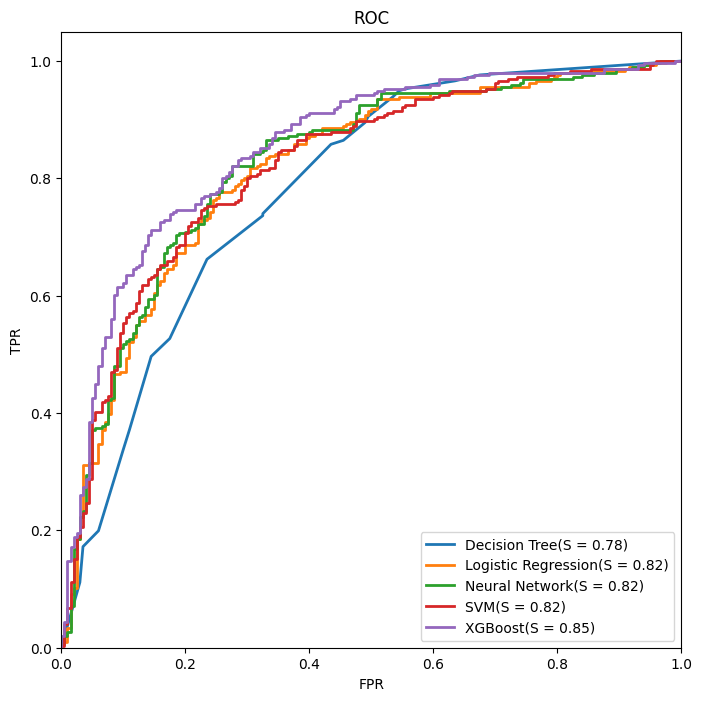

In [542]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 8))

models = [
    ('Decision Tree', clf),
    ('Logistic Regression', log_reg),
    ('Neural Network', mlp),
    ('SVM', svm_clf),
    ('XGBoost', xgb_clf)
]

for name, model in models:
    if name == 'SVM':
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, threshold = roc_curve(y_test, y_scores)
    
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label='%s(S = %0.2f)' % (name, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()


## t-SNE

In [543]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# normalize
scaler = StandardScaler()
data = scaler.fit_transform(X)


# for j in range(20):
# t-sne
tsne = TSNE(n_components=2, learning_rate=300, n_iter=10000, perplexity=30, metric='l1')
data_trans = tsne.fit_transform(data) 

# plot
cmap = plt.cm.Spectral
plt.figure(figsize=(6, 6))
for i in range(2):
    indices = y == i
    plt.scatter(data_trans[indices, 0], data_trans[indices, 1], color=cmap(i/1.1), label=i, s = 10)
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig(f'figs/neighbor.png')
plt.close()


f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## test

In [544]:
data_test.head()
print(data_test.shape)

(250, 43)


In [545]:
# data_test['label'] = data_test['label'].apply(lambda x: 1 if x == 'human' else 0)

data_test = data_test.drop('id', axis=1)


X = data_test[['label', 'url', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'verified', 'geo_enabled', 'lang',
                'statuses_count', 'profile_background_tile', 'profile_use_background_image', 'has_extended_profile', 'default_profile',
                'protected']].copy()

# 对 'url' 进行编码
# X['url'] = X['url'].apply(lambda x: 0 if x is None else 1)
X.loc[:, 'url'] = X['url'].apply(lambda x: 0 if x is None else 1)
X.loc[:, 'followers_count'] = np.log1p(X['followers_count'])
X.loc[:, 'friends_count'] = np.log1p(X['friends_count'])
X.loc[:, 'listed_count'] = np.log1p(X['listed_count'])
X.loc[:, 'favourites_count'] = np.log1p(X['favourites_count'])
X.loc[:, 'statuses_count'] = np.log1p(X['statuses_count'])

weekdays_mapping = {
    'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 
    'Fri': 5, 'Sat': 6, 'Sun': 7
}

split_columns = data_test['created_at'].str.split(' ', expand=True)
split_columns.columns = ['week', 'month', 'day', 'time', 'time_offset', 'zone_year']
time_split = split_columns['time'].str.split(':', expand=True)
time_split.columns = ['hour', 'minute', 'second']

X.loc[:, 'created_hour'] = time_split['hour'].astype(int)

X.loc[:, 'created_week'] = split_columns['week'].map(weekdays_mapping)


X.loc[:, 'geo_enabled'] = data_test['geo_enabled'].apply(lambda x: 1 if x else 0)
X.loc[:, 'verified'] = data_test['verified'].apply(lambda x: 1 if x else 0)
X.loc[:, 'profile_background_tile'] = data_test['profile_background_tile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'profile_use_background_image'] = data_test['profile_use_background_image'].apply(lambda x: 1 if x else 0)
X.loc[:, 'has_extended_profile'] = data_test['has_extended_profile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'default_profile'] = data_test['default_profile'].apply(lambda x: 1 if x else 0)
X.loc[:, 'protected'] = data_test['protected'].apply(lambda x: 1 if x else 0)
X.loc[:, 'notifications'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'default_profile_image'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'following'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'follow_request_sent'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'is_translation_enabled'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'is_translator'] = data_test['notifications'].apply(lambda x: 1 if x else 0)
X.loc[:, 'contributors_enabled'] = data_test['notifications'].apply(lambda x: 1 if x else 0)


language_mapping = {
    'en': 1, 'pt': 2, 'nl': 3, 'tr': 4, 'it': 5, 'th': 6, 'de': 7, 'en-gb': 8,
    'id': 9, 'es': 10, 'fr': 11, 'ru': 12, 'ar': 13, 'ca': 14, 'ja': 15,
    'pl': 16, 'ko': 17
}

X.loc[:, 'lang'] = data_test['lang'].map(lambda x: language_mapping.get(x, 18))



translator_type_mapping = {
    'none': 0,
    'regular': 1,
    'badged': 2
}
X['translator_type'] = data_test['translator_type'].map(lambda x: translator_type_mapping.get(x, 3))

def hex_to_int(hex_string):
    return int(hex_string, 16)

X['profile_text_color'] = data_test['profile_text_color'].apply(hex_to_int)
X['profile_sidebar_fill_color'] = data_test['profile_sidebar_fill_color'].apply(hex_to_int)
X['profile_sidebar_border_color'] = data_test['profile_sidebar_border_color'].apply(hex_to_int)
X['profile_link_color'] = data_test['profile_link_color'].apply(hex_to_int)
X['profile_background_color'] = data_test['profile_background_color'].apply(hex_to_int)





X.head()

,label,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,protected,created_hour,created_week,notifications,default_profile_image,following,follow_request_sent,is_translation_enabled,is_translator,contributors_enabled,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color
0,human,1,6.924612,6.343880,0.693147,9.245225,0,1,10,10.289498,1,1,1,0,0,17,6,0,0,0,0,0,0,0,1,3355443,14544630,16777215,9308922,16777215
1,human,1,14.224722,6.533789,7.807917,6.814543,1,1,1,8.701014,0,1,0,1,0,15,5,0,0,0,0,0,0,0,0,3355443,14544630,12639981,1942002,12639981
2,human,1,13.595989,7.173958,9.457825,9.364177,0,1,1,10.334035,1,1,0,0,0,20,2,0,0,0,0,0,0,0,1,3355443,15724527,15658734,39321,1250582
3,human,0,1.386294,3.912023,0.000000,0.000000,0,0,2,4.595120,0,1,0,1,0,18,3,0,0,0,0,0,0,0,0,3355443,14544630,12639981,1942002,16120058
4,human,1,11.552771,6.955593,4.477337,8.981807,0,1,10,9.871842,1,1,1,0,0,7,3,0,0,0,0,0,0,0,0,3548960,15028350,13382502,11799363,16737945


In [546]:
def categorize_similarity(name, screen_name):
    similarity = fuzz.partial_ratio(name, screen_name)
    if similarity == 0:
        return 0
    elif 0 < similarity <= 40:
        return 1
    elif 40 < similarity <= 70:
        return 2
    elif 70 < similarity <= 90:
        return 3
    else:
        return 4

X['name_similarity'] = data_test.apply(lambda row: categorize_similarity(row['name'], row['screen_name']), axis=1)


def extract_url_count_in_description(entities):
    try:
        urls = entities.get('description', {}).get('urls', [])
        return len(urls)
    except AttributeError:
        return 0

X['num_url_in_description'] = data_test['entities'].apply(extract_url_count_in_description)


def split_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' \g<0> ', text)  

def count_tokens(description):
    if pd.isna(description):
        return 0
    description = split_emoji(description)
    tokens = word_tokenize(description)
    return len(tokens)

X['token_num_description'] = data_test['description'].apply(count_tokens)


pd.set_option('display.max_columns', None)

X = X.drop('label', axis=1)
X = X.drop('protected', axis=1)
X = X.drop('notifications', axis=1)
X = X.drop('follow_request_sent', axis=1)
X = X.drop('contributors_enabled', axis=1)

X.head() 
# X.shape

,url,followers_count,friends_count,listed_count,favourites_count,verified,geo_enabled,lang,statuses_count,profile_background_tile,profile_use_background_image,has_extended_profile,default_profile,created_hour,created_week,default_profile_image,following,is_translation_enabled,is_translator,translator_type,profile_text_color,profile_sidebar_fill_color,profile_sidebar_border_color,profile_link_color,profile_background_color,name_similarity,num_url_in_description,token_num_description
0,1,6.924612,6.343880,0.693147,9.245225,0,1,10,10.289498,1,1,1,0,17,6,0,0,0,0,1,3355443,14544630,16777215,9308922,16777215,0,0,2
1,1,14.224722,6.533789,7.807917,6.814543,1,1,1,8.701014,0,1,0,1,15,5,0,0,0,0,0,3355443,14544630,12639981,1942002,12639981,3,1,27
2,1,13.595989,7.173958,9.457825,9.364177,0,1,1,10.334035,1,1,0,0,20,2,0,0,0,0,1,3355443,15724527,15658734,39321,1250582,1,0,25
3,0,1.386294,3.912023,0.000000,0.000000,0,0,2,4.595120,0,1,0,1,18,3,0,0,0,0,0,3355443,14544630,12639981,1942002,16120058,0,0,0
4,1,11.552771,6.955593,4.477337,8.981807,0,1,10,9.871842,1,1,1,0,7,3,0,0,0,0,0,3548960,15028350,13382502,11799363,16737945,2,3,11


In [547]:

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y_1 = xgb_clf.predict(X)


# y_pred.shape
print(y_1)

[1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1
 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1
 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0
 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1]


In [548]:
import json

with open('./data/test.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

for i, item in enumerate(data):
    label = 'bot' if y_1[i] == 0 else 'human'
    item['label'] = label

with open('./data/test.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=True, indent=4)


"import json\n\nwith open('./data/test.json', 'r', encoding='utf-8') as file:\n    data = json.load(file)\n\nfor i, item in enumerate(data):\n    label = 'bot' if y_1[i] == 0 else 'human'\n    item['label'] = label\n\nwith open('./data/test.json', 'w', encoding='utf-8') as file:\n    json.dump(data, file, ensure_ascii=True, indent=4)"